In [13]:
import numpy as np
import matplotlib.pyplot as plt
import json

f = open('../data/raw.chartblock.json')

data = json.load(f)
bids, asks = np.array(data[0]['ticks'])[:, 1], np.array(data[1]['ticks'])[:, 1]
n = bids.shape[0]

def get_bid_ask_from_future():
    for i, (bid, ask) in enumerate(zip(bids, asks)):
        yield i, bid, ask

In [14]:
generator = get_bid_ask_from_future()

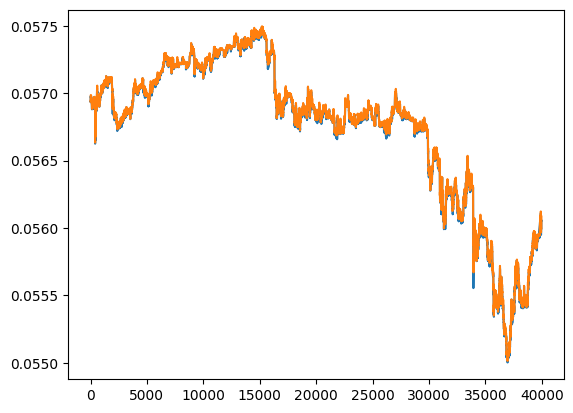

In [15]:
plt.plot(bids)
plt.plot(asks)

In [16]:
def check_valid(transactions):
    assert sum(np.sort(np.array(transactions).reshape(-1)) == np.array(transactions).reshape(-1)) == len(np.array(transactions).reshape(-1))
    assert len(set(np.array(transactions).reshape(-1))) == len(np.array(transactions).reshape(-1)), (len(set(np.array(transactions).reshape(-1))), len(np.array(transactions).reshape(-1)))
    for bid, ask in transactions:        
        assert asks[bid:ask+1].min() == asks[bid]
        assert bids[bid:ask+1].max() == bids[bid:ask+1][-1]

In [17]:
def calculate_profit(transactions):
    check_balance = 1
    profits = []
    for (buy, sell) in transactions:
        count = int(check_balance / asks[buy])
        check_balance += (bids[sell] - asks[buy]) * count
        profits.append((bids[sell] - asks[buy]) * count)
    return check_balance

In [18]:

generator = get_bid_ask_from_future()
balance = 1

def strategy(generator, balance):
    last_i, last_bid, last_ask = next(generator)
    min_ask = (last_ask, last_i)
    balance = 1
    transactions = []
    skip = False 
    while last_i != n - 1:
        if not skip:
            i, bid, ask = next(generator)
        else:
            skip = False
            
        min_ask = min_ask if min_ask[0] < last_ask else (last_ask, last_i)
        
        if bid > min_ask[0]:
            i_to_sell, bid_to_sell = i, bid
            while i != n - 1:
                i, bid, ask = next(generator)
                
                if bid >= bid_to_sell:
                    i_to_sell, bid_to_sell = i, bid 
                    continue
                
                new_min_ask = (ask, i)
                real_i_to_sell, real_bid_to_sell = i_to_sell, bid_to_sell
                while i != n - 1:
                    
                    i, bid, ask = next(generator)
                    if new_min_ask[0] >= ask:
                        new_min_ask = (ask, i)
                        real_i_to_sell, real_bid_to_sell = i_to_sell, bid_to_sell

                    if bid <= new_min_ask[0]:
                        if bid >= bid_to_sell:
                            i_to_sell, bid_to_sell = i, bid 
                    else:
                        skip = True
                        break

                transactions.append((min_ask[1], real_i_to_sell))
                balance += (real_bid_to_sell - min_ask[0]) * int(balance / min_ask[0])
                min_ask = new_min_ask
                break
            
        last_i, last_bid, last_ask = i, bid, ask 
    return balance, np.array(transactions)

final_balance, transactions = strategy(generator, balance)
print(final_balance)
check_valid(transactions)
print(calculate_profit(transactions)) 

1.5315539999999974
1.5315539999999974


In [31]:
%config InlineBackend.figure_format = 'retina'

def plt_arr(y, x, axis, title, label, log_scale=True, xlabel = None,  ylabel=None, bottom=None, top=None):
    axis.set_title(title)
    
    if xlabel:
        axis.set_xlabel(xlabel)
    if ylabel:
        axis.set_ylabel(ylabel)

    if bottom:
        axis.set_ylim(bottom=bottom)
    
    if top:
        axis.set_ylim(top=top)

    if log_scale:
        axis.set_yscale('log', base=10)
    
    axis.grid('on')
    axis.title.set_weight('bold')
    
    xlab = axis.xaxis.get_label()
    ylab = axis.yaxis.get_label()

    xlab.set_style('italic')
    xlab.set_size(15)
    ylab.set_style('italic')
    ylab.set_size(15)

    axis.plot(x, y, label = label)
    axis.scatter(x, y, c='purple', marker='D', s=1)

    axis.legend()

In [40]:
def build(left, right, transactions, axis):
    new_transactions0 = []
    for i in (transactions[:, 0]):
        if (left < i and i < right):
            new_transactions0.append(i)
            
    new_transactions1 = []
    for i in (transactions[:, 1]):
        if (left < i and i < right):
            new_transactions1.append(i)
    
    
    plt_arr(bids[left:right], np.arange(left, right), axis, 'buys/sells', 'bid')
    plt_arr(asks[left:right], np.arange(left, right), axis, 'buys/sells', 'ask')
    
    axis.scatter(new_transactions0, asks[new_transactions0], marker='^', color='g', s=40)
    axis.scatter(new_transactions1, bids[new_transactions1], marker='v', color='r', s=40)

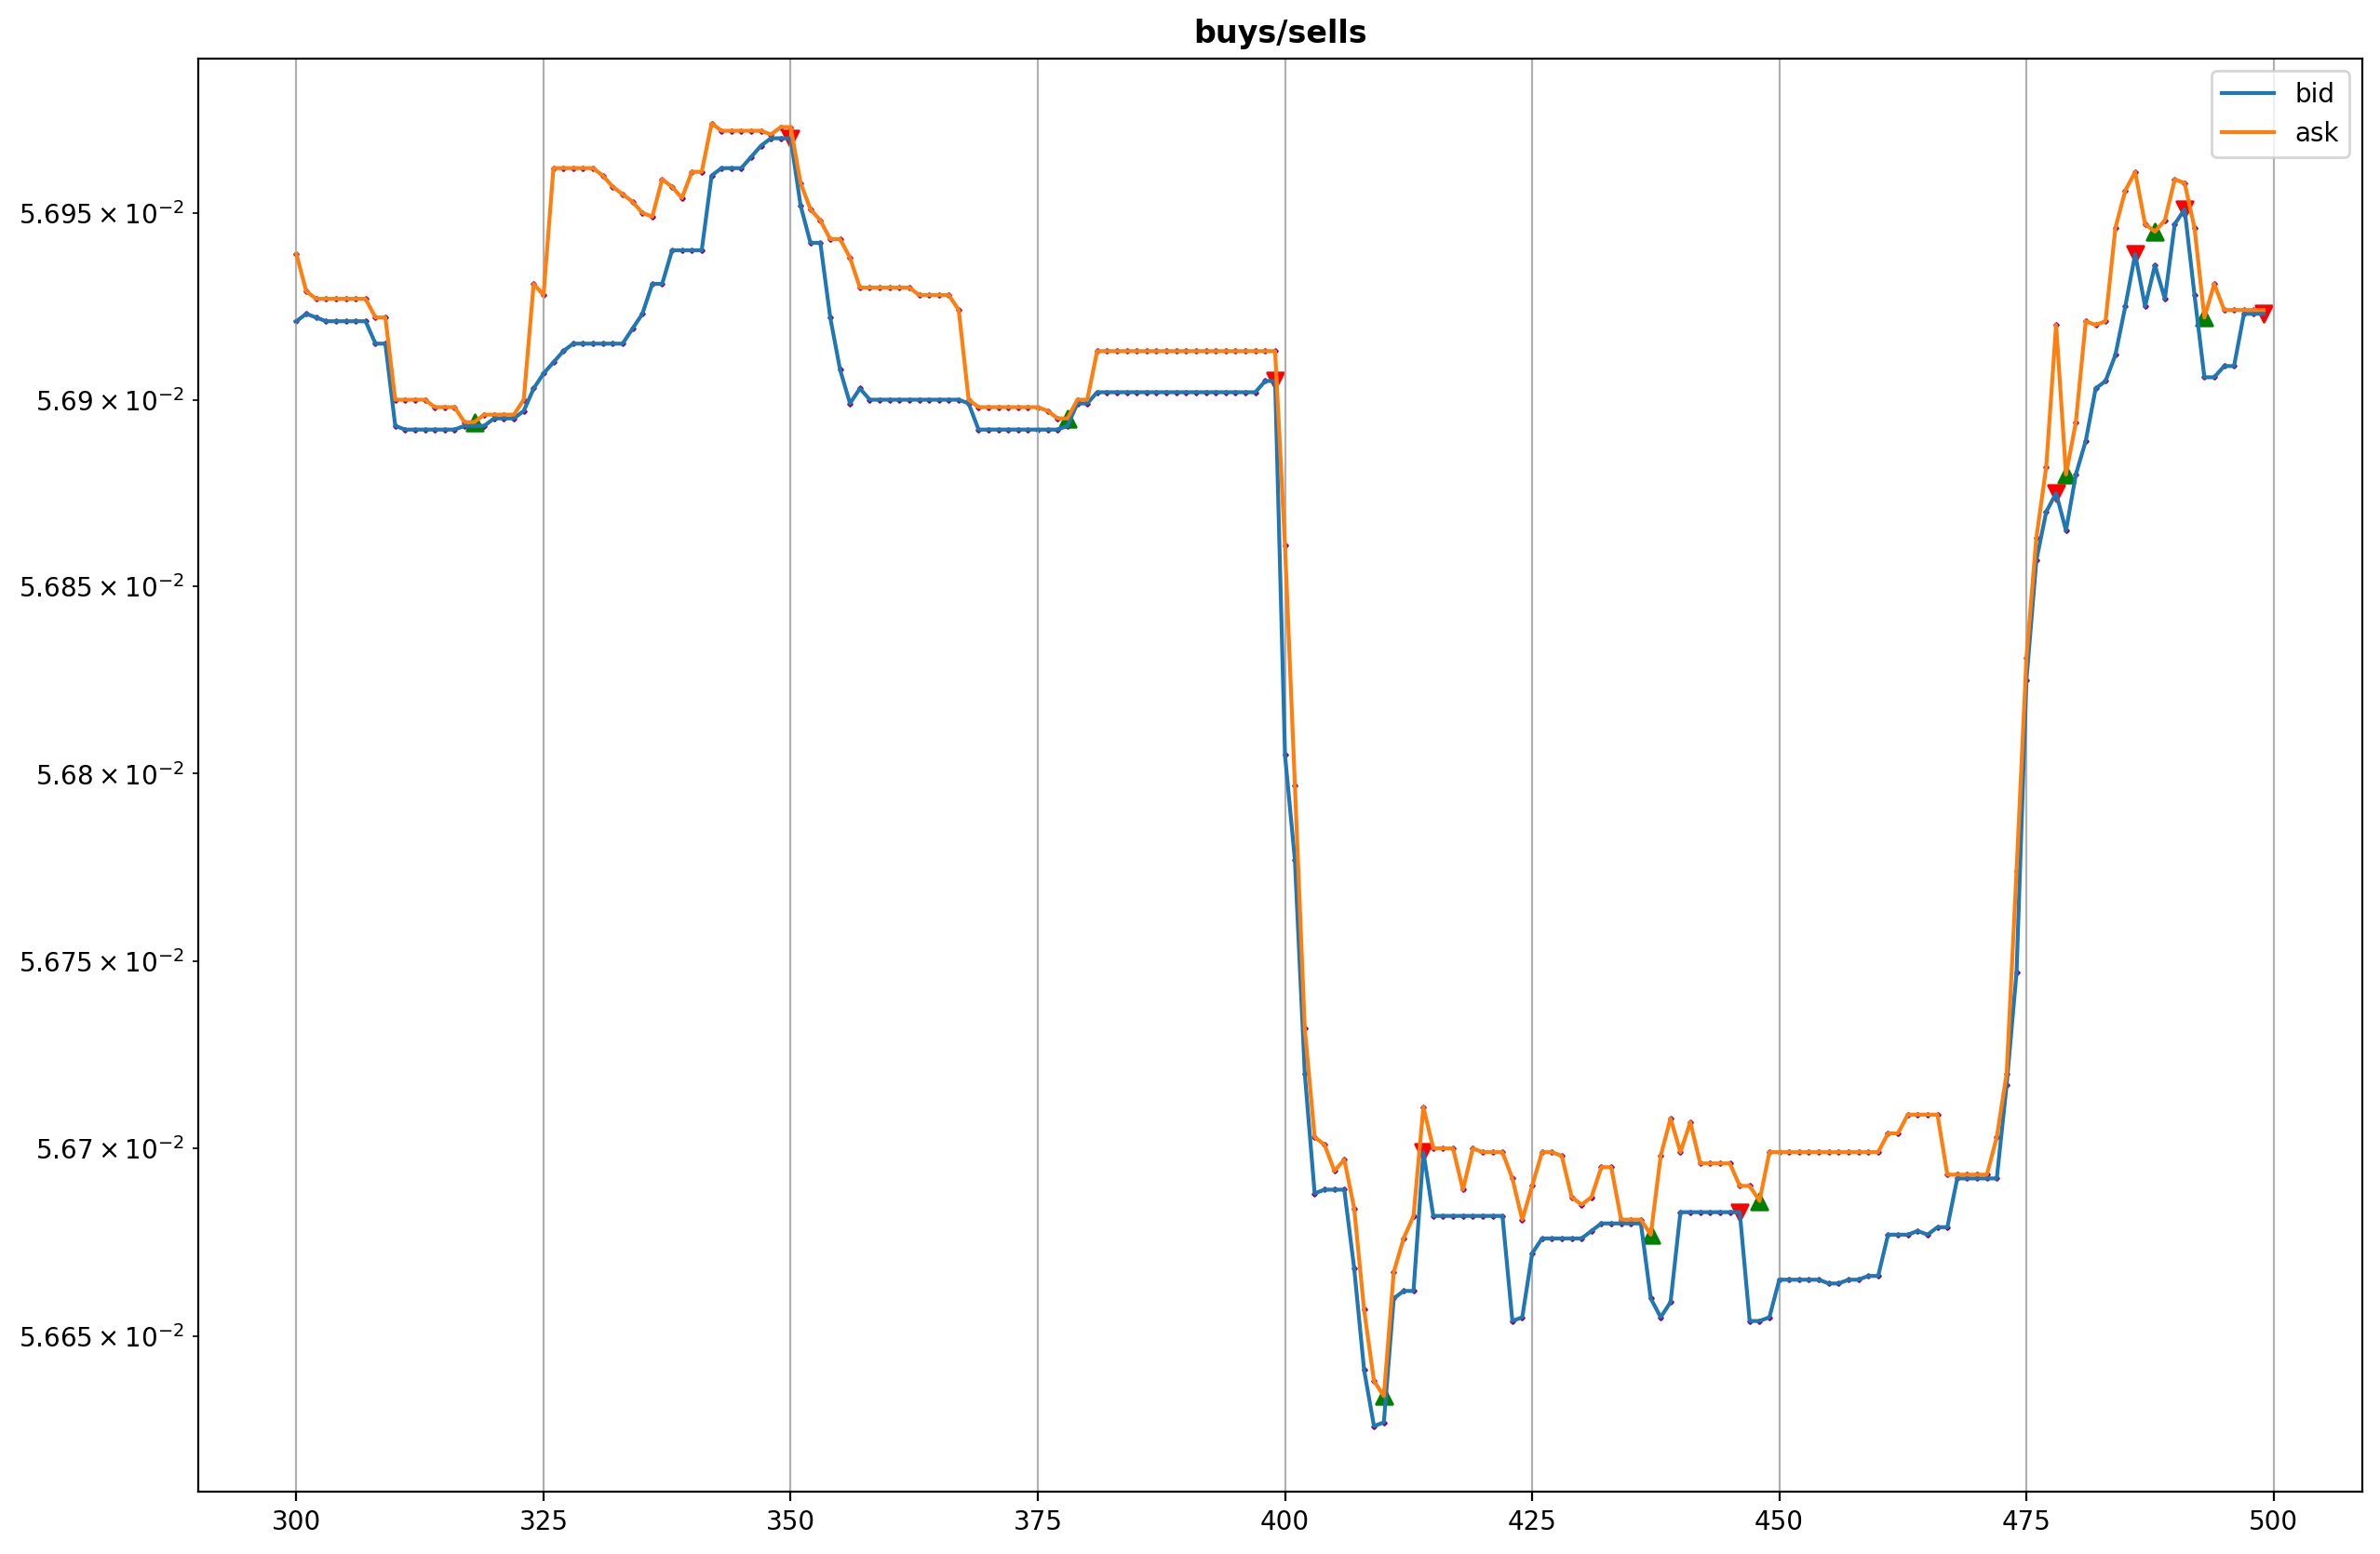

In [41]:
fig, axis = plt.subplots(figsize=(15, 10))
build(300, 500, transactions, axis) 